# Topic Classification using Naive Bayes

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [50]:
def Q1(num_examples=5):
    ### STUDENT START ###
    for i in range(num_examples):
        #pull the label at the ith index, this will show up as an integer value
        ind = train_labels[i]
        #print the name of the label using target_names
        print("Training Example", i, "Label:", newsgroups_train.target_names[ind])
        #print the content of the data at the ith index
        print("Training Example", i, "Message:\n", newsgroups_train.data[i])
    ### STUDENT END ###
Q1(5)

Training Example 0 Label: comp.graphics
Training Example 0 Message:
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Training Example 1 Label: talk.religion.misc
Training Example 1 Message:
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - f

### Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

In [4]:
def Q2():
    ### STUDENT START ###
    #Part 1 - Transform the training data into a matrix of word unigram feature vectors
    vectorizer = CountVectorizer()
    P1 = vectorizer.fit_transform(train_data)
    print("For Part 1...")
    #1A: Get vocabulary using the shape attribute
    print("The size of the vocabulary is", P1.shape[1])
    #1B: Average number of non-zero features per example 
    P1_nnz_ex = [P1[i].nnz for i in range(P1.shape[0])]
    P1_fin_av = round(sum(P1_nnz_ex) / len(P1_nnz_ex),6)
    #1C: fraction of the non-zero entries in the matrix
    frac_mat = round(P1.nnz/(P1.shape[0]*P1.shape[1]), 4) 
    #print out answers
    print("Average number of non-zero features per example:", P1_fin_av)
    print("Fraction of the non-zero entries in the matrix:", frac_mat)
    #get_feature_names() is already alphabetized, so just pull 0th and -1th index
    print("The 0th feature string is:", vectorizer.get_feature_names()[0])
    print("The last feature string is:", vectorizer.get_feature_names()[-1])
    
    #Part 2 - restrict the vocab
    print("For Part 2...")
    vectorizer = CountVectorizer(vocabulary = ["atheism", "graphics", "space", "religion"])
    P2 = vectorizer.transform(train_data)
    #Confirm the vocabulary size from shape attribute
    print("The size of the vocabulary is", P2.shape[1])
    #2A - Average number of non-zero features per example
    P2_nnz_ex = [P2[i].nnz for i in range(P2.shape[0])]
    P2_fin_av = round(sum(P2_nnz_ex) / len(P2_nnz_ex),6)
    print("Average number of non-zero features per example:", P2_fin_av)
    
    #Part 3 - character bigram and trigram feature vectors
    print("For Part 3...")
    vectorizer = CountVectorizer(analyzer = 'char', ngram_range=(2,3))
    P3 = vectorizer.fit_transform(train_data)
    #3A: Get vocabulary using the shape attribute
    print("The size of the vocabulary is", P3.shape[1])
    
    #Part 4 - prune words that appear in fewer than 10 documents
    print("For Part 4...")
    vectorizer = CountVectorizer(min_df = 10)
    P4 = vectorizer.fit_transform(train_data)
    #4A: Get vocabulary using the shape attribute
    print("The size of the vocabulary is", P4.shape[1])
    
    #Part 5 - Build vocabularies for both train and dev and look at the size of the difference
    print("For Part 5...")
    P5_vectorizer = CountVectorizer()
    P5_train = P5_vectorizer.fit_transform(train_data)
    train_vocab = list(P5_vectorizer.vocabulary_.keys())
    P5_dev = P5_vectorizer.fit_transform(dev_data)
    dev_vocab = list(P5_vectorizer.vocabulary_.keys())
    print("Training data vocabulary size:", P5_train.shape[1])
    print("Dev data vocabulary size:", P5_dev.shape[1])
    # num words in dev that are not in train / total number of words in dev
    not_in_train = [w for w in dev_vocab if w not in train_vocab]
    ans = len(not_in_train) / len(dev_vocab)
    print("Fraction of words in the dev vocab that's missing from training vocab is", round(ans,2))
    ### STUDENT END ###

Q2()

For Part 1...
The size of the vocabulary is 26879
Average number of non-zero features per example: 96.705998
Fraction of the non-zero entries in the matrix: 0.0036
The 0th feature string is: 00
The last feature string is: zyxel
For Part 2...
The size of the vocabulary is 4
Average number of non-zero features per example: 0.268437
For Part 3...
The size of the vocabulary is 35478
For Part 4...
The size of the vocabulary is 3064
For Part 5...
Training data vocabulary size: 26879
Dev data vocabulary size: 16246
Fraction of words in the dev vocab that's missing from training vocab is 0.25


### Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

In [3]:
def Q3():
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    new_train = vectorizer.fit_transform(train_data)
    new_dev = vectorizer.transform(dev_data)
    
    #KNN models
    k_values = [1,2,3,4,7,9,12,15,25]
    for i in k_values:
        #create KNN model with k = 1
        knn = KNeighborsClassifier(n_neighbors = i)
        #train the model on the mini training data provided
        knn.fit(new_train, train_labels)
        knn_pred = knn.predict(new_dev)
        knn_f1 = metrics.f1_score(dev_labels, knn_pred, average = "weighted")
        print("When k = {}, the F1 score is {:.4f}".format(i, knn_f1))
    
    #Naive Bayes models
    alphas = [1.0e-10, 0.001, 0.1, 0.5, 1.0, 2.0, 10.0]
    for a in alphas:
        nb = MultinomialNB(alpha = a)
        nb.fit(new_train, train_labels)
        nb_pred = nb.predict(new_dev)
        nb_f1 = metrics.f1_score(dev_labels, nb_pred, average = "weighted")
        print("When alpha = {}, the F1 score is {:.4f}".format(a, nb_f1))
    
    #Logistic Regression Models
    c_vals = [.01, 0.05, .1, .2, .3, .5, 1, 2, 5, 10]
    for c in c_vals:
        lr = LogisticRegression(C = c, solver = "liblinear", multi_class = "auto")
        #fit and pred on vectorized train and dev data
        lr.fit(new_train, train_labels)
        lr_pred = lr.predict(new_dev)
        lr_f1 = metrics.f1_score(dev_labels, lr_pred, average = "weighted")
        ssw = []
        #loop through all weights to calculate the sum of squared weights
        for i in range(lr.coef_.shape[0]):
            squ = [x ** 2 for x in lr.coef_[i]]
            ssw.append(sum(squ))
        print("When C = {}:\n F1 score is {:.4f}".format(c,lr_f1))
        print("Sum of squared weights is", ssw)
    
    ### STUDENT END ###

Q3()

When k = 1, the F1 score is 0.3805
When k = 2, the F1 score is 0.3805
When k = 3, the F1 score is 0.4084
When k = 4, the F1 score is 0.4031
When k = 7, the F1 score is 0.4505
When k = 9, the F1 score is 0.4366
When k = 12, the F1 score is 0.4211
When k = 15, the F1 score is 0.4326
When k = 25, the F1 score is 0.4161
When alpha = 1e-10, the F1 score is 0.7472
When alpha = 0.001, the F1 score is 0.7703
When alpha = 0.1, the F1 score is 0.7903
When alpha = 0.5, the F1 score is 0.7863
When alpha = 1.0, the F1 score is 0.7777
When alpha = 2.0, the F1 score is 0.7690
When alpha = 10.0, the F1 score is 0.6675
When C = 0.01:
 F1 score is 0.6647
Sum of squared weights is [2.541478743984131, 2.939709368361363, 2.862467836458274, 2.2497877552920813]
When C = 0.05:
 F1 score is 0.6867
Sum of squared weights is [14.073967727717658, 13.668380010357769, 14.604297323772386, 11.860677350612479]
When C = 0.1:
 F1 score is 0.6966
Sum of squared weights is [27.13220960993868, 24.667992353486742, 27.458105

KNN models are very susceptible to overfitting due to the curse of dimensionality. This phenomenon occurs for this application because the feature space becomes increasingly sparse for an increasing number of dimensions of a fixed-size training dataset. Because of this, even the closest neighbors are too far away in a high-dimensional space to give a good estimate.

Naive Bayes is more successful than Logistic Regression for this text classification application likely due to the sample size. We know that as training size reaches infinity, the logistic regression model performs better than the Naive Bayes model. Naive Bayes also assumes that each of the features (the words in the document) are conditionally independent, this gives the Naive Bayes model a higher bias but lower variance compared to logistic regression. The dataset in this case follows that bias, so it produces a better classifier.

As C increase, so do the sum of squared weights, because both are inversely related to the regularization parameter.

### Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

In [3]:
def Q4():
    ### STUDENT START ###
    #transform the data into bigram feature vectors using the analyzer and ngram_range parameters
    vectorizer = CountVectorizer(analyzer = 'word', ngram_range=(2,2))
    new_train = vectorizer.fit_transform(train_data)
    #pull in the vocabulary 
    vocab = vectorizer.get_feature_names()

    #create LR model using the provided arguments
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(new_train, train_labels)

    #create empty index list of 20 zeroes
    indices = np.zeros(20, dtype=int)
    for i in range(len(newsgroups_train.target_names)):
        #pull the coefs for each label and sort them using argsort, pull top 5 
        topic_coefs = np.array(lr.coef_[i])
        coef_sort = np.argsort(topic_coefs)
        top_5 = coef_sort[-5:]
        #save these five indices into the empty list
        indices[i*5:(i+1)*5] = top_5
        print("Top 5 features for the topic {}:".format(newsgroups_train.target_names[i]))
        features = []
        #pull the vocab words from vocab with the corresponding index
        features = [vocab[i] for i in top_5]
        print(features)
    
    #create new list of the vocab words and create a dataframe using the bigrams as the index column
    all_20_ft = [vocab[i] for i in indices]
    df = pd.DataFrame(index = all_20_ft)
    
    #add column to dataframe for the weights for each category
    for i in range(len(newsgroups_train.target_names)):
        colname = newsgroups_train.target_names[i]
        df[colname]=lr.coef_[i,indices]

    print(df)
    
    ### STUDENT END ###

Q4()

Top 5 features for the topic alt.atheism:
['are you', 'you are', 'was just', 'cheers kent', 'claim that']
Top 5 features for the topic comp.graphics:
['is there', 'out there', 'comp graphics', 'in advance', 'looking for']
Top 5 features for the topic sci.space:
['it was', 'and such', 'sci space', 'the moon', 'the space']
Top 5 features for the topic talk.religion.misc:
['of jesus', 'but he', 'ignorance is', 'cheers kent', 'the fbi']
               alt.atheism  comp.graphics  sci.space  talk.religion.misc
are you           0.446954      -0.248265  -0.097153           -0.305622
you are           0.472741      -0.279893  -0.481327            0.028378
was just          0.482050      -0.131429  -0.128921           -0.227467
cheers kent       0.555719      -0.697906  -0.663762            0.534808
claim that        0.605549      -0.199053  -0.274361           -0.140364
is there         -0.340882       0.754979  -0.468275           -0.257080
out there        -0.274802       0.758674  -0.479056

Answer: A couple of the bigrams seem interesting to me. For starters, "the FBI" having a high weight for the topic of religion. Also, "cheers kent" appears twice, having high weights for the topics of atheism *and* religion. I did some research and apparently Kent Hovind is a prominent christian evangelist, so it makes sense that his name is referenced. 

### Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

In [11]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandradrossos/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [44]:
def p1_preprocessor(doc):
    return(doc)

def my_test(doc):
    return None

#credit to: https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
def my_preprocessor(doc):
    #lower all the words
    doc = doc.lower()
    
    #remove all the stop wods in the nltk corpus
    sw_nltk = stopwords.words('english')
    words = [word for word in doc.split() if word.lower() not in sw_nltk]
    doc = " ".join(words)
    
    #replace numbers with just 'num'
    doc = re.sub('\d+', 'num', doc)
    doc = re.sub('[^(a-zNUM)]', ' ', doc)
    
    #replace all the contractions with their expanded meanings
    contractions = ["could've", "would've", "should've", "hasn't", "wasn't", "aren't", "'s", "didn't"]
    subs = ["could have", "would have", "should have", "has not", "was not", "are not", " is ", "did not"]
    for i in range(len(contractions)):
        doc = re.sub(contractions[i], subs[i], doc)
    doc = ' '.join([x[:5] for x in doc.split()])
    
    return(doc)

In [45]:
def Q5():
    ### STUDENT START ###
    #create vectorizer using the identity function pre processor function
    p1_vectorizer = CountVectorizer(preprocessor = p1_preprocessor)
    #create training, dev, and pull vocab
    p1_new_train = p1_vectorizer.fit_transform(train_data)
    p1_new_dev = p1_vectorizer.transform(dev_data)
    p1_vocab = p1_vectorizer.get_feature_names()
    
    #create LR model with provided parameters, fit it, predict, and calculate f1 score
    lr = LogisticRegression(C = 0.5, solver = "liblinear", multi_class = "auto")
    lr.fit(p1_new_train, train_labels)
    lr_pred = lr.predict(p1_new_dev)
    lr_f1 = metrics.f1_score(dev_labels, lr_pred, average = "weighted")
    print("Using no preprocessing, the logistic regression model returned:")
    print("F1 score: {:.4f}".format(lr_f1))
    print("Vocabulary size: {}".format(len(p1_vocab)))
    
    #create improved logistic regression model with custom pre processor function
    p2_vectorizer = CountVectorizer(preprocessor = my_preprocessor)
    p2_new_train = p2_vectorizer.fit_transform(train_data)
    p2_new_dev = p2_vectorizer.transform(dev_data)
    p2_vocab = p2_vectorizer.get_feature_names()
    
    #calculate improved f1 score
    lr_2 = LogisticRegression(C = 0.5, solver = "liblinear", multi_class = "auto")
    lr_2.fit(p2_new_train, train_labels)
    lr_2_pred = lr_2.predict(p2_new_dev)
    lr_2_f1 = metrics.f1_score(dev_labels, lr_2_pred, average = "weighted")
    f1_improve = lr_2_f1 - lr_f1
    #print answers
    print("Using custom preprocessing, the improved logistic regression model returned:")
    print("F1 score: {:.4f}".format(lr_2_f1))
    print("Vocabulary size: {}".format(len(p2_vocab)))
    print("Pre-processing improved the model by {}".format(round(f1_improve, 4)))
    print("The improved model reduced the vocabulary size by {} words".format(len(p1_vocab) - len(p2_vocab)))
    ### STUDENT END ###

Q5()

Using no preprocessing, the logistic regression model returned:
F1 score: 0.7069
Vocabulary size: 33291
Using custom preprocessing, the improved logistic regression model returned:
F1 score: 0.7292
Vocabulary size: 15036
Pre-processing improved the model by 0.0223
The improved model reduced the vocabulary size by 18255 words


### L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

         Full_Vocab_F1  Reduced_Vocab_Size  Reduced_Vocab_F1  Log_vocab
0.01          0.422986                  17            0.4678   2.833213
0.05          0.586772                 125            0.6403   4.828314
0.10          0.642458                 211            0.6925   5.351858
0.20          0.696025                 383            0.6697   5.948035
0.30          0.692867                 538            0.6702   6.287859
0.50          0.683432                 789            0.6706   6.670766
1.00          0.696291                1090            0.6913   6.993933
2.00          0.694018                1746            0.6853   7.465083
5.00          0.681363                2690            0.7012   7.897296
10.00         0.658163                3401            0.6927   8.131825
20.00         0.653787                4112            0.6935   8.321665
50.00         0.644203                6072            0.6887   8.711443
100.00        0.620856                7711            0.6951   8

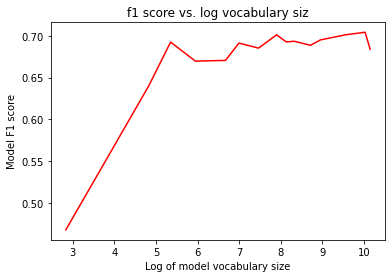

In [12]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    #vectorize train and dev data and pull the original vocabulary 
    vectorizer = CountVectorizer()
    new_train = vectorizer.fit_transform(train_data)
    new_dev = vectorizer.transform(dev_data)
    og_vocab = np.array(vectorizer.get_feature_names_out())
    
    #try various L1 regularization strengths
    c_vals = [.01, 0.05, .1, .2, .3, .5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
    #create dictionary to eventually become a dataframe
    d={'Full_Vocab_F1':[],'Reduced_Vocab_Size':[],'Reduced_Vocab_F1':[]}
    for c in c_vals:
        #create and fit LR model with provided parameters
        lr = LogisticRegression(C = c, solver = "liblinear", tol=.015, penalty="l1")
        lr.fit(new_train, train_labels)
        lr_pred = lr.predict(new_dev)
        #get accuracy of model with full vocabulary
        full_vocab_score = metrics.f1_score(dev_labels, lr_pred, average = "weighted")
        d['Full_Vocab_F1'].append(full_vocab_score)
        #get the indices where the coef_ is not 0
        non_zeros = np.sum(lr.coef_ != 0, axis = 0) != 0
        #reduce the vocab to be just the words with non-zero weights
        new_vocab=og_vocab[non_zeros]
        #pull length of the new vocabulary and add it to the vocab_size column
        d['Reduced_Vocab_Size'].append(len(new_vocab))
        
        #vectorize data with the updated vocabulary
        l2_vectorizer = CountVectorizer(vocabulary = new_vocab)
        l2_new_train = l2_vectorizer.fit_transform(train_data)
        l2_new_dev = l2_vectorizer.transform(dev_data)
        
        #get the f1 score of the new model 
        lr_2 = LogisticRegression(C = 0.5, solver = "liblinear", tol=.015, penalty="l2") 
        lr_2.fit(l2_new_train, train_labels)
        lr_2_pred = lr_2.predict(l2_new_dev)
        lr_2_f1 = metrics.f1_score(dev_labels, lr_2_pred, average = "weighted")
        d['Reduced_Vocab_F1'].append(round(lr_2_f1,4))
    #create dataframe from dictionary and set index to be the L1 Regularization strengths   
    df = pd.DataFrame(d, index = c_vals)
    #take the log of the vocabulary size for the graph
    df["Log_vocab"] = np.log(df["Reduced_Vocab_Size"])
    
    print(df)
    
    #plot f1 score vs. log of vocab size
    plt.plot(df["Log_vocab"], df["Reduced_Vocab_F1"],
            color='red')
    plt.xlabel('Log of model vocabulary size')
    plt.ylabel('Model F1 score')
    plt.title('f1 score vs. log vocabulary siz')
    plt.show()
        
    ### STUDENT END ###

Q6()

ANSWER: Comparing the F1 scores of the models using the full vocabulary vs. the "feature selected" reduced vocabulary, we can see that reducing the vocabulary by removing the words with zero weights improves the F1 scores for each L1 regularization strength that we tried.

### TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [14]:
def Q7():
    ### STUDENT START ###
    #vectorize the train and dev data using the TFIDF vectorizer
    vectorizer = TfidfVectorizer()
    new_train = vectorizer.fit_transform(train_data)
    new_dev = vectorizer.transform(dev_data)
    
    #create LR model, fit, predict, and calculate F1 score
    lr = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr.fit(new_train, train_labels)
    lr_pred = lr.predict(new_dev)
    lr_f1 = metrics.f1_score(dev_labels, lr_pred, average = "weighted")
    print("F1 Score for Logistic Regression Model using Tfidf Vectorizer: {:.4f}".format(lr_f1))
    
    #pull in the probabilities from the model
    probs=lr.predict_proba(new_dev)
    
    #calculate r ratios
    #create empty list to store values
    r_ratios = []
    #loop through whole dev_data
    for i in range(len(dev_labels)):
        # r ratio = maximum predicted probability / predicted probability of the correct label 
        r_ratio = max(probs[i]) / probs[i,dev_labels[i]]
        r_ratios.append(r_ratio)
    r_ratios = np.array(r_ratios)
    
    #sort the r ratios using arg sort
    ratios_sort = np.argsort(r_ratios)
    #because these are sorted in ascending order and we want the highest 3, take the last 3 of the list
    top_3 = ratios_sort[-3:]
    
    #print the predicted label, true label, r-ratio, and document content
    for j in top_3:
        print("R ratio: {:.4f}".format(r_ratios[j]))
        print("Predicted Label: {}".format(newsgroups_train.target_names[lr_pred[j]]))
        print("True Label: {}".format(newsgroups_train.target_names[dev_labels[j]]))
        print("Document: {} \n".format(dev_data[j]))
    ### STUDENT END ###

Q7()

F1 Score for Logistic Regression Model using Tfidf Vectorizer: 0.7598
R ratio: 287.1792
Predicted Label: talk.religion.misc
True Label: alt.atheism
Document: 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...
 

R ratio: 325.0040
Predicted Label: comp.graphics
True Label: talk.religion.misc
Document: Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 

R ratio: 929.3573
Predicted Label: comp.graphics
True Label: talk.religion.misc
Document: I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
hav

The Tfidf vectorizer assigns a weight to each work which signifies its importance for a document that belongs in a corpus.  The weight a word is assigned increases proportionally to the number of times the word appears in the document. It's also offset by the number of documents in the corpus that contain the word to adjust for words that appear more frequently in general. In contrast, the CountVectorizer just returns a vector of integers corresponding to the number of times a word is used in a document. In terms of performance, the model that used the Tfidf vectorizer produced a higher accuracy (f1_score = .76) than the model using the count vectorizer (f1_score = .62). 

The r-ratio basically represents how *off* our prediction was based on the probabilities that we associated to each label. The higher the r-ratio, the farther off we were. Computer graphics and religion were mistaken mostly in these 3 examples because users would use terms like 'internet'. 